# Goal<br>
* Develop a machine learning model using bag of words and vectorization that will take in Netflix descriptions of shows in it's database and predict wether the show matching each discription belongs to a given genre<br>

* Inestigate wether this technique can be inhanced by identifying "unique words," words that only occur in discriptions belonging to that genre

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e
import model as m

#pd.set_option('display.max_colwidth', None)

# Wrangle

* Data acquired from [Kaggle](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)

* Each row in the data represents a show appearing on Netflix at the time data was collected
* Columns were restricted to description and genre
* The following modifications were made when cleaning the text in description
     * Converted to lowercase
     * Special characters removed
     * Remove non-ascii characters
     * Lemmatize tokens
     * Remove stop words using standard list plus two letter words
* Boolean columns for each genre appearing in the genres column were added 
     * These columns indicate if the show belonged to that genre
* Dataset contains 5791 rows after being prepared 
* full dataset was split into train, validate and test sets 
     * Train set contains 3242 rows
     * Validate set contains 1390 rows
     * Test set contains 1159 rows

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")
print(f"Validate set contains {validate.shape[0]} rows of data")
print(f"Test set contains {test.shape[0]} rows of data")

Train set contains 3242 rows of data
Validate set contains 1390 rows of data
Test set contains 1159 rows of data


# Explore

## 1. Choose a genre as a test case using the following criteria:
   * Genre has large representation in the data
   * Genre has a large number of unique words
   * Genre has a high number of unique words appearing in each description
   * Genre is relatively easy for a human to intuit 

## 2. Explore the chosen genre:
   * How much of the data is represented by the chosen genre?
   * What is the distribution of word and document frequency for the chosen genre?
   * What words have the highest and lowest word and document frequency?
   * Is it possible to predict the chosen genre using unique words?

In [3]:
# get set of genres
gen_set = e.get_gens(train)

# get relative word frequency list and list of only the numbers
word_freq = e.get_word_freq(train)
word_counts = e.get_counts(word_freq)

# get relative document frequency list and list of only the numbers
doc_freq = e.get_doc_freq(train)
doc_counts = e.get_counts(doc_freq)

## 1. Choose a Test Case 

### What is the distribution of genres in the train data?

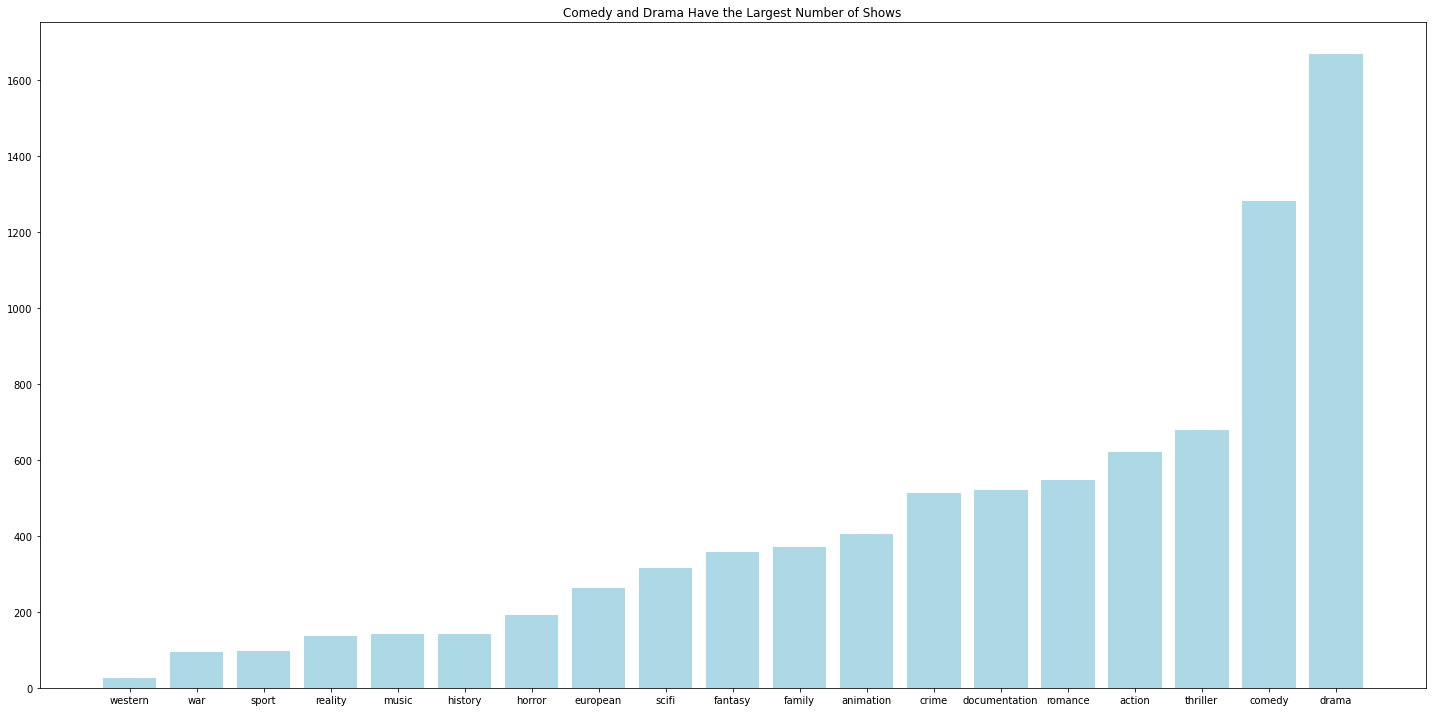

In [4]:
# display distribution of genres
shows_per_gen = e.get_shows_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Comedy and Drama Have the Largest Number of Shows")

* Comedy and Drama are by far the most highly represented genre in the training data.

### How many different unique words appear in each genre? 

* **Unique Words** are words that appear in the descriptions of films in a given genre but do not appear in descriptions of films that are not in that genre

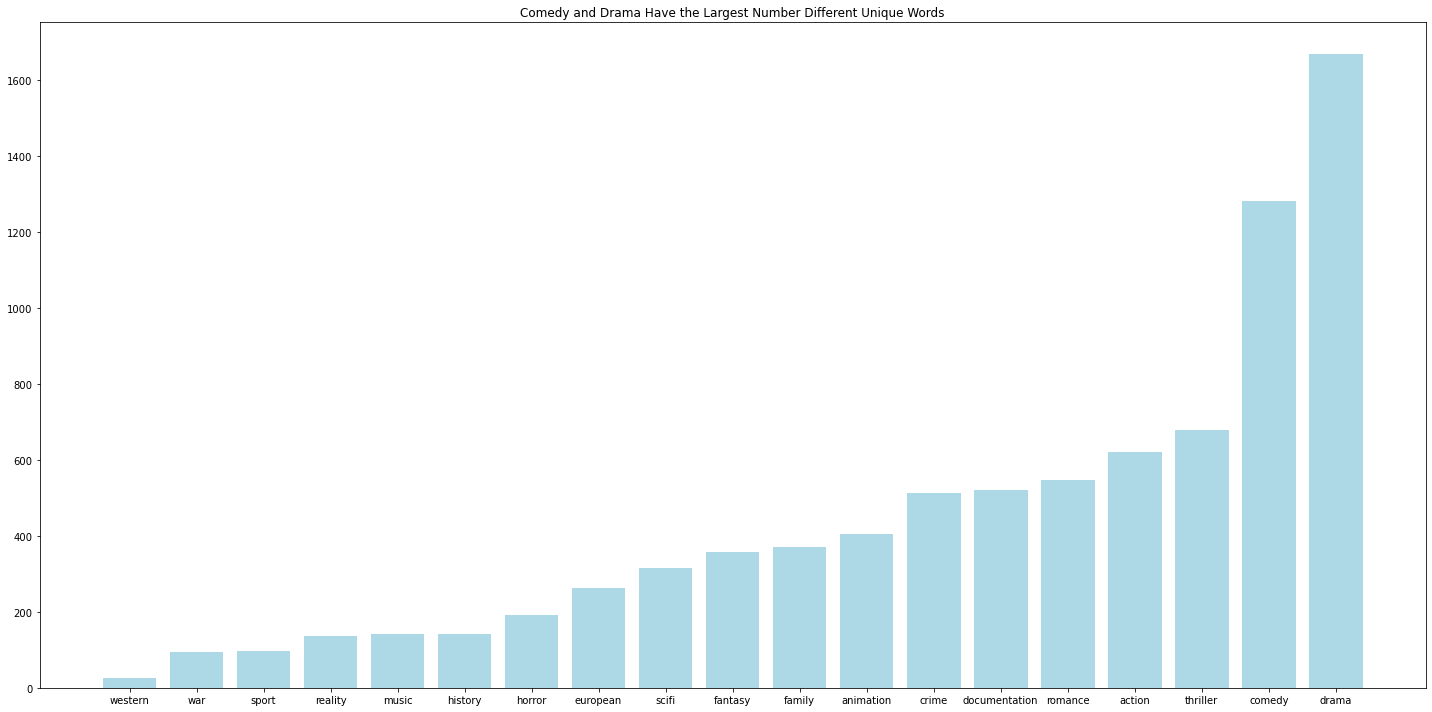

In [5]:
# display number of different unique words in each genre
unique_words_per_gen = e.get_unique_words_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Comedy and Drama Have the Largest Number Different Unique Words")

* Comedy and Drama contain by far the largest number of differint unique words

### What is the average number of times unique words appear in descriptions of each genre?

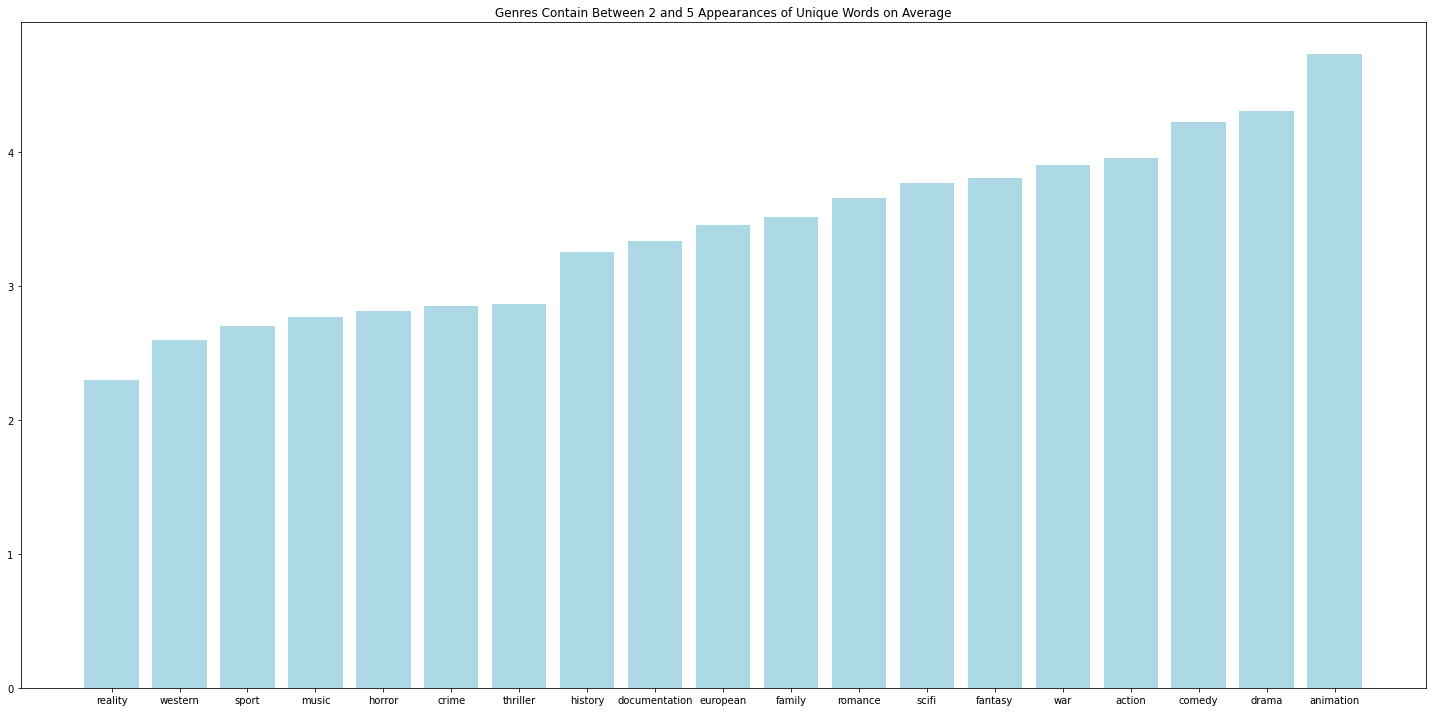

In [6]:
# get frequency of unique words pre genre
unique_word_appearance_per_genre = e.get_unique_word_appearance_per_genre(train, gen_set)
e.get_bar(unique_word_appearance_per_genre, "Genres Contain Between 2 and 5 Appearances of Unique Words on Average")

* Not a great deal of variance in unique word appearance frequency
* Animation has the highest appearace frequency
* Comedy and Drama are close behind

## Test Case Conclution

* Comedy and Drama have high values in all of the testable criterea
   * Representation in the data
   * Number of unique words
   * High number of unique words appearing in each description
* Either genre would make a reasonable choice
* The last criteria is how easily the genre would be to intuit for a human
    * Comedy seems to me the earier of the two genres for a human to intuit 

**For these reasons I am choosing comedy as the test case for this project**

## 2) Explore the Comedy Genre

* What percent of the data is classified as a Comedy?
* Are there any words that appear more or less frequently across comedy or non-comedy show descriptions? <br>(Overall/by document)

## How much of the data is Comedy?

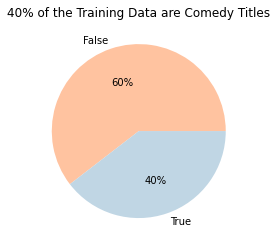

In [7]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

## What does the relative occurance of words in comedy or non-comedy films tell us?

I will look at two seperate measures:
* **Relative Word Frequency**
    * Calculated by adding the number of times a given word appears in comedy film descriptions and subtracting the number of times that word appears in non-comedy film descriptions
* **Relative Document Frequency**
    * Calculated by adding the number of comedy descriptions a given word appears in and subtracting the number of non-comedy films the word appears in

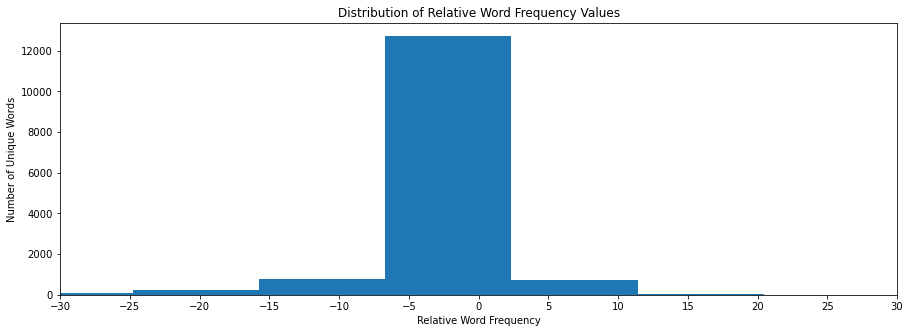

In [8]:
e.get_hist(word_counts,"Distribution of Relative Word Frequency Values","Relative Word Frequency")

* Observations:
    * Data appears to normalize around -2 
    * There is a negative skew to the data likely due to a 60/40 imbalance in the data
    
* Takeaways:
    * There are a lot of numbers at values close to zero. This indicates that there are a large number of words that do not strongly indicate whether a film is comedy or non-comedy. Removing these "low value" numbers may reduce noise in the model
    * Because of the negative skew in the data words that have a high negative value may have it due the data imbalance meaning they are not true indicators of non_comedy films
    * Because the skew favors negative values it is more likely that words with positive values are true indicators of comedy films 

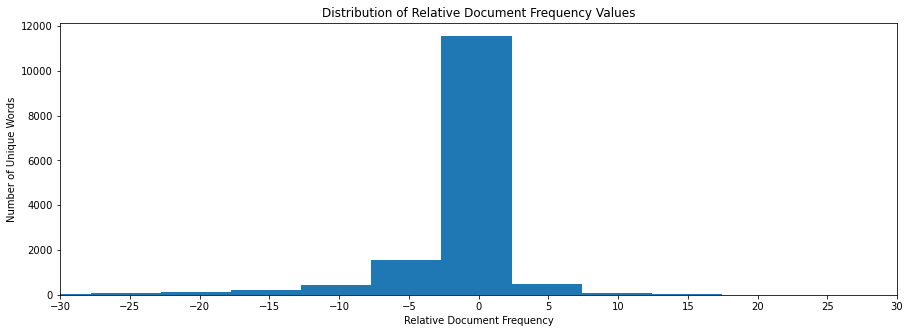

In [9]:
e.get_hist(doc_counts, "Distribution of Relative Document Frequency Values","Relative Document Frequency")

* Observations:
    * Data appears to normalize around 0 
    * There is a negative skew to the data likely due to a 60/40 imbalence in the data
    
* Takeaways:
    * There are a lot of numbers at values close to zero this indicates that there are a large number of words that do not strongly indicate whether a film is comedy or non-comedy. Removing these "low value" numbers may reduce noice in the model
    * Because of the negative skew in the data, words that have a high negative value may have it due the data imbalance meaning they are not true indicators of non_comedy films
    * Because the skew favors negative values it is more likely that words with positive values are true indicators of comedy films 

## What do the most extreme 15 most extreme positive and negative frequency values tell us?

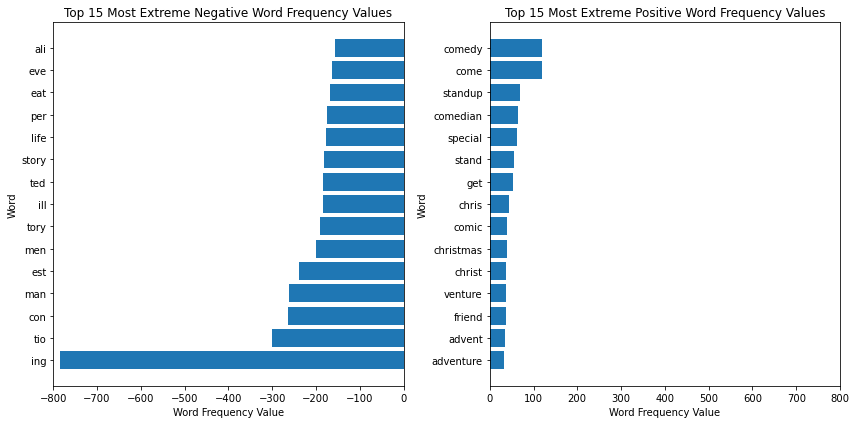

In [10]:
e.display_ext_values(dict(word_freq[:15]),"Top 15 Most Extreme Negative Word Frequency Values", dict(word_freq[-15:]), "Top 15 Most Extreme Positive Word Frequency Values","Word Frequency Value", "Word", 800)

* Observations
    * Exteme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
* Takeaways
    * This gives further evidence that low value words may be common words that appear more frequently in non-comedy films due to data imbalance
    * This also gives further evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitivly indicative of comedy films 

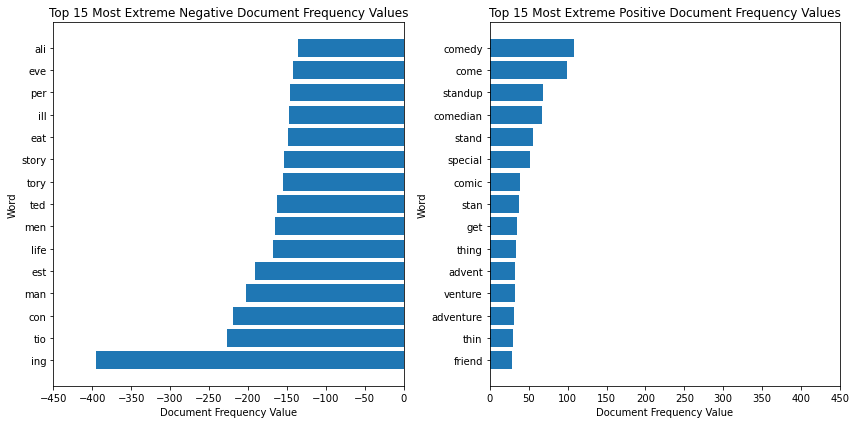

In [11]:
e.display_ext_values(dict(doc_freq[:15]), "Top 15 Most Extreme Negative Document Frequency Values", dict(doc_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values", "Document Frequency Value", "Word", 450)

* Observations
    * Exteme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
* Takeaways
    * This gives evidence that low value words may be common words that appear more frequently in non-comedy films due to the data imbalance
    * This also gives further evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitivly indicative of comedy films 

## Exploration Summary

* Data Split
    * Training data has a 60/40 split of comedy and non-comedy data
* Relative Frequency Distribution
    * Relative frequency metrics both showed that values normalize around values close to zero. Values close to or at zero are likely not indicative of whether a film is comedy or non-comedy. Removing these values will likely reduce noise in the model
    * Both metrics indicate a negative skew likely do to an imbalance in the data
    * Word frequency seems to be more skewed than Document frequency
* Extreme Value Words
    * Extreme positive values are much closer to zero than their negative counterparts and include words that are intuitively indicative of comedy such as comedy, comedian, and standup
    * Extreme negative values are much farther from zero and do not include words that are intuitively indicative of non-comedy films
    * This gives evidence that low value words may be common words that appear more frequently in non-comedy films due to the data imbalance
    * This also gives evidence that high value words are likely to be strong indicators of comedy films due to surviving the imbalance and being intuitively indicative of comedy films 


# Predictions Using Unique Words

On average 4 or more unique words will apear in the description of each comedy film. Based on this I will test weather I can predict if a film is a comedy or non-comedy by using the presence or absence of unique words. I will use the following method:

* Unique words for comedy and non-comedy will be identified using train data and used to predict validate data
* Values will be assigned to each prediction according the presence/number of unique comedy and non-comedy words
* Prediction methods will be evaluated in terms of overall accuracy and override accuracy
    * Overall Accuracy = total correct predictions / total attempted predictions
        * Non-Boolian results will count as missed predictions
    * Override Accuracy = total correct True or False predictions / Total True or False predictions
        * Non-Boolian results will not be considered
* I will use two methods of prediction:
    * Presence of unique words
        * Has unique words for comedy and no unique words for non-comedy = True
        * Has unique words for non-comedy and no unique words for comedy = False
        * Has both = Has Both 
        * Has niether = Contains Niether
    * Majority of unique words
        * Has more comedy unique words than non-comedy unique words = True
        * Has more non-comedy unique words than comedy unique words = False
        * Has an equal number of comedy and non-comedy unique words = Equal Count
        * Has niether = Has Niether
* Due to the 60/40 split in the data I am setting the baseline accuracy of 60% 

If the overall accuracy of this prediction method is high enough it could be used as an alternative to traditional modeling. If override accuracy beats a given models overall accuracy it could be used in conjunction with traditional modeling to override model results where the prediction method produces a boolean result.

In [12]:
# get set of words occuring in comedy and non-comedy descriptions
com_train = e.get_description_set_of_words(train[train.comedy == True])
non_train = e.get_description_set_of_words(train[train.comedy == False])

# get set of words appearing in only comedy or non-comedy descriptions
com_unique_train = com_train.difference(non_train)
non_unique_train = non_train.difference(com_train)

# get train and validate dataframes with only description and comedy columns
train_evaluation_df = train[['description','comedy']]
validate_evaluation_df = validate[['description','comedy']]

# Sanity Test - Predicting Train Using Presence of Unique Words 

In [13]:
m.get_predictions_presence(train_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False               1837
True                1168
contains niether     237
Name: prediction, dtype: int64

Evaluation Results
-----------------------
True     3005
False     237
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
93.0

Override Accuracy
-----------------------
100.0


* Sanity Test performed as expected 
* This method produced the same number of incorrect predictions and contains niether results giving evidence that
    * All of the train data cases that contain unique words for either comedy or non-comedy correctly identified 
    * Those that did not were classified as contains niether 

# Predicting Validate Using Presence of Unique Words 

In [14]:
m.get_predictions_presence(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
contains both       512
False               486
contains niether    213
True                179
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    941
True     449
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
32.0

Override Accuracy
-----------------------
68.0


* Overall Accuracy is very poor due to a large number of films that either contained uique words from both comedy and non-comedy or contained no unique words
* Even when considering only True/False predictions Override accuracy is only 8% above baseline
* I do not recommend using this method of prediction

# Predicting Validate Using Number of Unique Words 

In [15]:
m.get_predictions_number(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False          739
equal count    379
True           272
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    708
True     682
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
49.0

Override Accuracy
-----------------------
67.0


* Overall Accuracy improves, but is still below baseline. Increase is likely due to increasing the number of True/False predictions it could make.
    * 512 predictions were lost in the previous method because they contained both types of unique words
    * 213 predictions were lost in the previous method because they contained no unique words
    * 725 predictions were lost all together the
    * 317 predictions were lost in the current method due to having an equal number of comedy and non-comedy unique words
    * 408 additional predictions were made using this method
* Override Accuracy is slightly worse using this method at 7% above baseline


## Predicting Using Unique Words Conclution

* Baseline 60% 
* Predicting on Presence of Unique Words 
    * Overall Accuracy of 32% is far below baseline
    * Override Accuracy of 68% is slightly better than baseline
        * If a given model's accuracy is less I would consider using this method as an override if the overridden model is less than 68% accurate.
* Predicting on Number of Unique Words
    * Overall Accuracy of 49% is far below baseline
    * Override Accuracy of 67% is worse than predicting on presence alone
        * If a given model's accuracy is less I would consider using this method as an override if the overridden model is less than 67% accurate.
* Takeaways
    * At the moment I do not recommend using either method to make predictions
        * Overall accuracy is below baseline on both
        * Using is as an override is only usefull if the model being overridden is predicting less accuratly thant the  method, and I don't think 
    * Adjustments may be possible
        * Perhaps predicting based on totaling the relative frequency of each word in the description would yield better results
            * I would need to adjust how relative frequency is measured to avoid skewing the results due to data imbalance
                * perhaps using percentage of appearances instead of number of appearances.

# Modeling

* I will examine two types of vectorization arrays
   * Count - Each word is assigned a number value for each film counting the number of times it appears in the description
   * TF-IDF - Each word is assigned a number value for each film in a calculation which lowers the value based on the number of descriptions in the data it appears in and raises the value based on the number of times the word appears in the discription of the film
* I will examine feature engineering using relative frequency
    * I will examine two differint measures
        * Relative frequency by total number of times the word appears in all documents (film descriptions)
        * Relative frequency by number of documents (film descriptions) that contain the word
    * I will choose a threshold for removal
    * Words with a relative frequency between negative threshold and threshold will be removed 
    * Results of predictions made using differint machine learning models will be compared before removing any columns and after removing columns at differint thresholds
        * Thresholds used will be 0, 5, 20, 50, and 100
* I will examine results of differint machine learning models
    * Decision Tree
    * Random Forest
    * K Nearist Neighbors
    * Logistic Regression
* Models will be evaluated in terms of overall accuracy 
* Because of the 60/40 split in the data baseline will be set at 60%

## Note !

* Model evaluation take a long time to run! For this reason the code that runs the evaluations in the notebook has been commented out and replaced with a Markdown table displaying the results. Feel free to uncomment that code in your cloned notebook to run the model results for yourself.

In [16]:
# seperate train, validate and test data into X (description) and y (comedy)
train_X = train[['description']].reset_index(drop=True)
train_y = train[['comedy']].reset_index(drop=True)

validate_X = validate[['description']].reset_index(drop=True)
validate_y = validate[['comedy']].reset_index(drop=True)

test_X = test[['description']].reset_index(drop=True)
test_y = test[['comedy']].reset_index(drop=True)

## Count Analysis - Full Vectorization Array

In [17]:
# vectorize discriptions using counts
train_counts, validate_counts, test_counts = m.get_vector_counts(train_X, validate_X, test_X)

In [18]:
# runs model evaluations, uncomment the following to run the model evaluations for yourself 

# m.get_acc_table(train_counts, train_y, validate_counts, validate_y)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 64.82%               |
| Nothing Removed | Random Forest       | 99.97%            | 69.86%               |
| Nothing Removed | K Neighbors         | 62.86%            | 60.50%               |
| Nothing Removed | Logistic Regression | 99.78%            | 71.80%               |

## Count Analysis - Drop low Relative Frequency - Raw Counts

In [19]:
for item in [0,5,20,50,100]:
    
    m.get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, word_freq, item)

Drop threshold is 0
Accuracy Scores
---------------
Decision Tree  Train: 99.97% Validate: 65.97%
Random Forest  Train: 99.97% Validate: 70.07%
K Neighbors  Train: 63.13999999999999% Validate: 60.22%
Logistic Regression Train: 99.6% Validate: 71.94%
Drop threshold is 5
Accuracy Scores
---------------
Decision Tree  Train: 99.94% Validate: 63.88%
Random Forest  Train: 99.94% Validate: 70.22%
K Neighbors  Train: 80.35% Validate: 58.63%
Logistic Regression Train: 88.99000000000001% Validate: 69.28%
Drop threshold is 20
Accuracy Scores
---------------
Decision Tree  Train: 98.11999999999999% Validate: 61.8%
Random Forest  Train: 98.11999999999999% Validate: 65.18%
K Neighbors  Train: 75.44999999999999% Validate: 60.5%
Logistic Regression Train: 75.72% Validate: 69.64%
Drop threshold is 50
Accuracy Scores
---------------
Decision Tree  Train: 80.97% Validate: 63.239999999999995%
Random Forest  Train: 80.97% Validate: 64.46%
K Neighbors  Train: 70.82000000000001% Validate: 62.519999999999996

KeyboardInterrupt: 

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 64.82%               |
|   0             | Decision Tree       | 99.97%            | 65.97%               |
|   5             | Decision Tree       | 99.94%            | 63.88%               |
|  20             | Decision Tree       | 98.12%            | 61.80%               |
|  50             | Decision Tree       | 80.97%            | 63.24%               |
| 100             | Decision Tree       | 67.40%            | 62.52%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | 69.86%               |
|   0             | Random Forest       | 99.97%            | 70.07%               |
|   5             | Random Forest       | 99.94%            | 70.22%               |
|  20             | Random Forest       | 98.11%            | 65.18%               |
|  50             | Random Forest       | 80.97%            | 64.46%               |
| 100             | Random Forest       | 67.40%            | 62.59%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 62.86%            | 60.50%               |
|   0             | K Neighbors         | 63.14%            | 60.22%               |
|   5             | K Neighbors         | 80.35%            | 58.63%               |
|  20             | K Neighbors         | 75.45%            | 60.50%               |
|  50             | K Neighbors         | 70.82%            | 62.52%               |
| 100             | K Neighbors         | 63.63%            | 58.35%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 99.78%            | 71.80%               |
|   0             | Logistic Regression | 99.60%            | 71.94%               |
|   5             | Logistic Regression | 88.99%            | 69.28%               |
|  20             | Logistic Regression | 75.72%            | 69.64%               |
|  50             | Logistic Regression | 68.72%            | 66.04%               |
| 100             | Logistic Regression | 64.10%            | 63.31%               |

## Count Analysis - Drop low Relative Frequency - Document Counts

In [ ]:
# for item in [0,5,20,50,100]:

#     get_acc_after_freq_drop(train_counts, train_y, validate_counts, validate_y, doc_freq, item)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 64.82%               |
|   0             | Decision Tree       | 99.97%            | 65.90%               |
|   5             | Decision Tree       | 99.94%            | 63.45%               |
|  20             | Decision Tree       | 97.90%            | 59.93%               |
|  50             | Decision Tree       | 77.64%            | 63.74%               |
| 100             | Decision Tree       | 66.38%            | 62.73%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | 69.86%               |
|   0             | Random Forest       | 99.97%            | 70.22%               |
|   5             | Random Forest       | 99.94%            | 69.57%               |
|  20             | Random Forest       | 97.90%            | 65.18%               |
|  50             | Random Forest       | 77.64%            | 64.75%               |
| 100             | Random Forest       | 66.38%            | 62.52%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 62.86%            | 60.50%               |
| 0               | K Neighbors         | 63.39%            | 60.36%               |
| 5               | K Neighbors         | 81.0%             | 56.91%               |
| 20              | K Neighbors         | 75.94%            | 59.14%               |
| 50              | K Neighbors         | 67.30%            | 57.99%               |
| 100             | K Neighbors         | 60.18%            | 56.55%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 99.78%            | 71.80%               |
| 0               | Logistic Regression | 99.54%            | 71.37%               |
| 5               | Logistic Regression | 87.79%            | 70.29%               |
| 20              | Logistic Regression | 74.61%            | 68.56%               |
| 50              | Logistic Regression | 67.98%            | 66.62%               |
| 100             | Logistic Regression | 63.97%            | 63.02%               |

## TFIDF Analysis - Full Vectorization Array

In [ ]:
def get_vectorized_data(train_X, validate_X, test_X, vector):
    ''' Take in X values for train, validate and test
        Return values vectorized by count'''

    cv = vector

    train_X = cv.fit_transform(train_X['description'])
    validate_X = cv.transform(validate_X['description'])
    test_X = cv.transform(test_X['description'])

    # Retrieve the feature names (words) from the Vectorizer
    feature_names = cv.get_feature_names()

    # Create DataFrames for train_counts and validate_counts
    train_X = pd.DataFrame(train_X.todense(), columns=feature_names)
    validate_X = pd.DataFrame(validate_X.todense(), columns=feature_names)
    test_X = pd.DataFrame(test_X.todense(), columns=feature_names)

    return train_X, validate_X, test_X

In [ ]:
train_tfidf, validate_tfidf, test_tfidf = get_vectorized_data(train_X, validate_X, test_X, TfidfVectorizer())

In [ ]:
# m.get_acc_table(train_tfidf, train_y, validate_tfidf, validate_y)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 61.58%               |
| Nothing Removed | Random Forest       | 99.97%            | 70.00%               |
| Nothing Removed | K Neighbors         | 80.35%            | 67.63%               |
| Nothing Removed | Logistic Regression | 88.25%            | 70.43%               |

# Word

In [ ]:
# for item in [0,5,20,50,100]:
    
#     get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, word_freq, item)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 61.58%               |
|   0             | Decision Tree       | 99.97%            | 62.30%               |
|   5             | Decision Tree       | 99.97%            | 60.14%               |
|  20             | Decision Tree       | 99.23%            | 59.86%               |
|  50             | Decision Tree       | 92.69%            | 60.65%               |
| 100             | Decision Tree       | 82.54%            | 57.34%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | 70.00%               |
|   0             | Random Forest       | 99.97%            | 69.93%               |
|   5             | Random Forest       | 99.97%            | 67.05%               |
|  20             | Random Forest       | 99.23%            | 64.75%               |
|  50             | Random Forest       | 92.69%            | 62.88%               |
| 100             | Random Forest       | 82.54%            | 58.85%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 80.35%            | 67.63%               |
| 0               | K Neighbors         | 40.78%            | 40.00%               |
| 5               | K Neighbors         | 84.15%            | 55.11%               |
| 20              | K Neighbors         | 75.85%            | 59.71%               |
| 50              | K Neighbors         | 72.92%            | 62.88%               |
| 100             | K Neighbors         | 67.77%            | 60.43%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 88.25%            | 70.43%               |
| 0               | Logistic Regression | 87.51%            | 71.01%               |
| 5               | Logistic Regression | 77.76%            | 69.50%               |
| 20              | Logistic Regression | 71.16%            | 68.35%               |
| 50              | Logistic Regression | 67.15%            | 66.55%               |
| 100             | Logistic Regression | 63.60%            | 63.02%               |

# Doc

In [ ]:
# for item in [0,5,20,50,100]:
    
#     get_acc_after_freq_drop(train_tfidf, train_y, validate_tfidf, validate_y, doc_freq, item)

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Decision Tree       | 99.97%            | 61.58%               |
|   0             | Decision Tree       | 99.97%            | 61.08%               |
|   5             | Decision Tree       | 99.94%            | 59.06%               |
|  20             | Decision Tree       | 99.14%            | 61.01%               |
|  50             | Decision Tree       | 90.90%            | 61.58%               |
| 100             | Decision Tree       | 81.40%            | 57.34%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Random Forest       | 99.97%            | 70.00%               |
|   0             | Random Forest       | 99.97%            | 69.86%               |
|   5             | Random Forest       | 99.94%            | 68.27%               |
|  20             | Random Forest       | 99.14%            | 64.96%               |
|  50             | Random Forest       | 90.90%            | 63.09%               |
| 100             | Random Forest       | 81.40%            | 58.56%               |

| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | K Neighbors         | 80.35%            | 67.63%               |
| 0               | K Neighbors         | 73.63%            | 50.07%               |
| 5               | K Neighbors         | 86.21%            | 56.76%               |
| 20              | K Neighbors         | 75.91%            | 59.42%               |
| 50              | K Neighbors         | 70.57%            | 59.50%               |
| 100             | K Neighbors         | 67.06%            | 60.86%               |


| Threshold       | Model               | Accuracy On Trian | Accuracy on Validate |
|-----------------|---------------------|-------------------|----------------------|
| Nothing Removed | Logistic Regression | 88.25%            | 70.43%               |
| 0               | Logistic Regression | 87.11%            | 70.36%               |
| 5               | Logistic Regression | 77.79%            | 70.00%               |
| 20              | Logistic Regression | 70.85%            | 68.20%               |
| 50              | Logistic Regression | 66.35%            | 66.62%               |
| 100             | Logistic Regression | 63.63%            | 63.02%               |